# 1. 필요한 패키지 로드

In [64]:
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import array_to_img

import random
import os

import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers

print('tensorflow version: {}'.format(tf.__version__))

tensorflow version: 2.1.0


# 2. 데이터셋 경로, 파라미터 선언

In [83]:
Path = './data/dataset'
epochs=50
batch_size = 16

# 3. 데이터셋  , 데이터 증식

In [66]:
imageGenerator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.3, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=.1
)

trainGen = imageGenerator.flow_from_directory(
    os.path.join(Path, 'train'),
    batch_size = batch_size,
    target_size=(128, 128),
    subset='training'
)

validationGen = imageGenerator.flow_from_directory(
    os.path.join(Path, 'train'),
    batch_size = batch_size,
    target_size=(128, 128),
    subset='validation'
)
    

Found 284 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


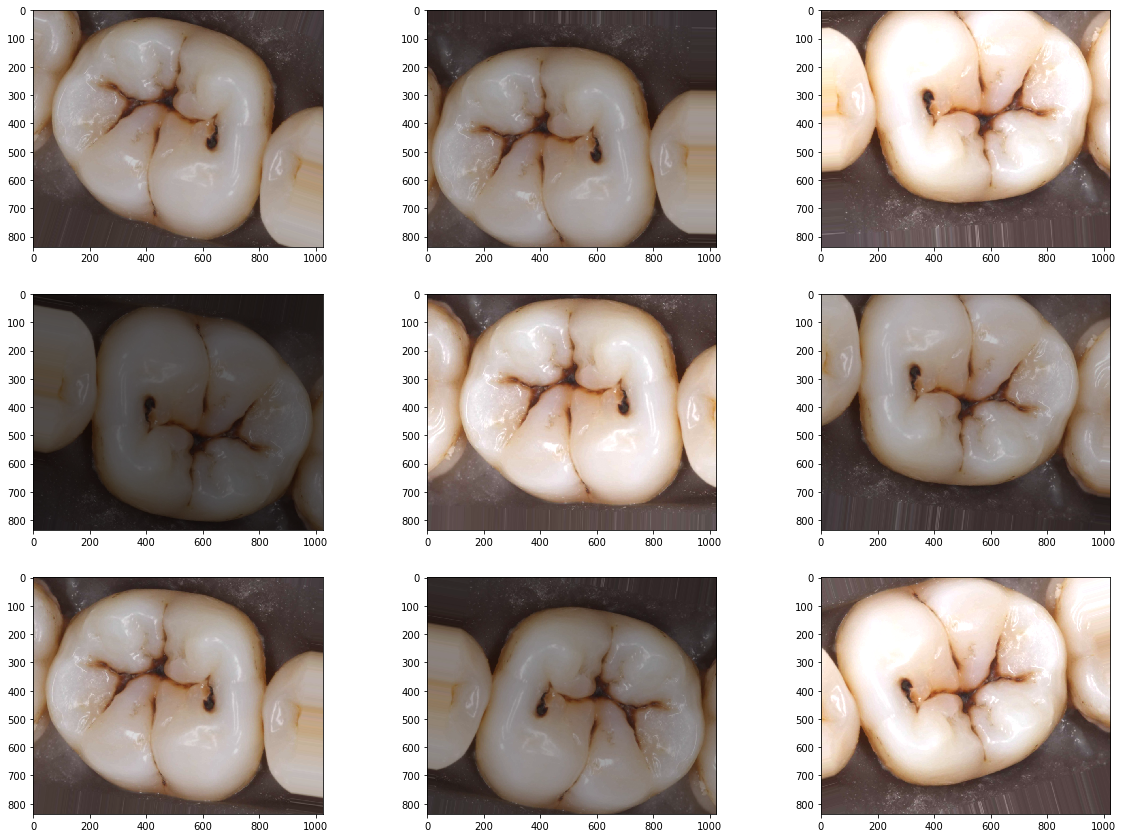

In [71]:
from tensorflow.keras.preprocessing.image import img_to_array
from numpy import expand_dims
img = load_img('./data/dataset/train/cavity/17.jpg')
data = img_to_array(img)
sample = expand_dims(data,0)
Generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.3, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=.1
)
it = Generator.flow(sample,batch_size=1)
fig = plt.figure(figsize = (20,20))
for i in range(9):
    plt.subplot(4,3,1+i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

# 5. 네트워크 설계

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential()


model.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu',input_shape=(128, 128, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(rate=0.25))

model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(rate=0.25))

model.add(layers.Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(rate=0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(2, activation='softmax'))



model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_13 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_14 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 64)       

In [69]:
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

# 6. Training

In [70]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                           patience=5,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00001)
callbacks=[earlystop,learning_rate_reduction]

In [91]:
history = model.fit(
    trainGen, 
    epochs=epochs,
    steps_per_epoch= (trainGen.samples//batch_size),
  
    validation_data=validationGen
   ,callbacks=callbacks
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 17 steps, validate for 8 steps
Epoch 1/50
17/17 [==============================] - 8s 495ms/step - loss: 0.4951 - accuracy: 0.7647 - val_loss: 0.4631 - val_accuracy: 0.7667
Epoch 2/50
17/17 [==============================] - 8s 461ms/step - loss: 0.4247 - accuracy: 0.8235 - val_loss: 0.6006 - val_accuracy: 0.8000
Epoch 3/50
17/17 [==============================] - 8s 465ms/step - loss: 0.5476 - accuracy: 0.7794 - val_loss: 0.4464 - val_accuracy: 0.8333
Epoch 4/50
17/17 [==============================] - 8s 456ms/step - loss: 0.4040 - accuracy: 0.7941 - val_loss: 0.4468 - val_accuracy: 0.8333
Epoch 5/50
17/17 [==============================] - 8s 448ms/step - loss: 0.6353 - accuracy: 0.7500 - val_loss: 0.6245 - val_accuracy: 0.8333
Epoch 6/50
17/17 [==============================] - 8s 468ms/step - loss: 0.3874 - accuracy: 0.8088 - val_loss: 0.4051 - val_accuracy: 0.8000
Epoch 7/50
17/17 [==============================] - 8s 46

In [33]:
model.save("model.h5")

In [7]:
model = tf.keras.models.load_model('model.h5')

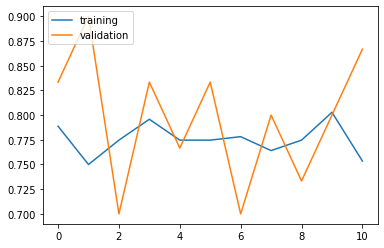

In [89]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [46]:
def show_graph(history_dict):
    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(16, 2))
    
    plt.subplot(121)
    plt.subplots_adjust(top=2)
    plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Trainging and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()

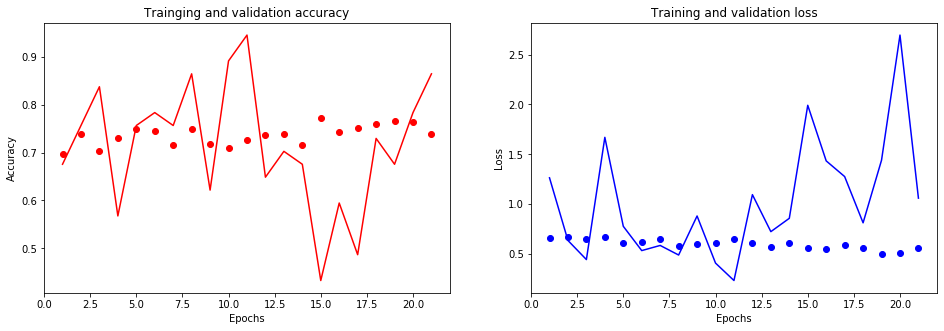

In [47]:
show_graph(history.history)

In [77]:
testGenerator = ImageDataGenerator(
    rescale=1./255
)

testGen = testGenerator.flow_from_directory(
    os.path.join(Path, 'test'),
    target_size=(128, 128)
)

Found 22 images belonging to 2 classes.


In [86]:
results = model.evaluate(testGen)

  ...
    to  
  ['...']
1/1 [==============================] - 0s 484ms/step - loss: 0.4604 - accuracy: 0.8636


In [87]:
print('Test accuracy: ', results[1])

Test accuracy:  0.8636364


예측: 충치
정답: 충치


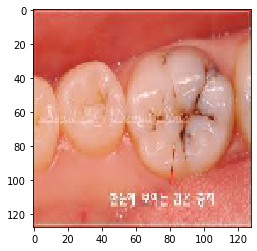

In [50]:
cls_index = ['충치', '정상치']

imgs = testGen.next()
arr = imgs[0][0]
img = array_to_img(arr).resize((128, 128))
result = model.predict_classes(arr.reshape(1, 128, 128, 3))
plt.imshow(img)
print('예측: {}'.format(cls_index[result[0]]))
print('정답: {}'.format(cls_index[np.argmax(imgs[1][0])]))



In [23]:
#faster-rcnn